In [1]:
FILENAME = "fullfile_ascii_3.csv"

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
import lime
import lime.lime_tabular
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack

In [3]:
df = pd.read_csv(FILENAME, low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1788003 entries, 0 to 1788002
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Unnamed: 0                int64  
 1   backers_count             int64  
 2   blurb                     object 
 3   category                  object 
 4   converted_pledged_amount  float64
 5   country                   object 
 6   goal                      float64
 7   id                        int64  
 8   location                  object 
 9   name                      object 
 10  photo                     int64  
 11  pledged                   float64
 12  spotlight                 int64  
 13  staff_pick                int64  
 14  state                     int64  
 15  usd_pledged               float64
 16  video                     int64  
 17  prelaunch_activated       int64  
 18  is_liked                  int64  
 19  is_disliked               int64  
 20  is_starrable            

In [5]:
df['state'].value_counts()

state
1    1123662
0     664341
Name: count, dtype: int64

In [6]:
df['video'].value_counts()

video
1    1243983
0     544020
Name: count, dtype: int64

In [7]:
df['photo'].value_counts()

photo
1    1787768
0        235
Name: count, dtype: int64

In [8]:
df["blurb"] = df["blurb"].astype(str)

In [9]:
df = df.drop(columns=['Unnamed: 0','id','name','location'])

In [10]:
df_sampled = df.sample(n=10000, random_state=42).reset_index(drop=True)

In [11]:
df_sampled["state"].value_counts()

state
1    6261
0    3739
Name: count, dtype: int64

In [12]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'goal', 'photo', 'pledged', 'spotlight', 'staff_pick',
       'state', 'usd_pledged', 'video', 'prelaunch_activated', 'is_liked',
       'is_disliked', 'is_starrable', 'blurb_wc', 'dale_chall',
       'flesch_kincaid', 'smog', 'gun_fog', 'camp_len'],
      dtype='object')

In [13]:
X_blurb = df_sampled["blurb"]
y = df_sampled["state"]
X_other = df_sampled.drop(columns=["blurb", "state"])

In [14]:
X_other

,backers_count,category,converted_pledged_amount,country,goal,photo,pledged,spotlight,staff_pick,usd_pledged,...,prelaunch_activated,is_liked,is_disliked,is_starrable,blurb_wc,dale_chall,flesch_kincaid,smog,gun_fog,camp_len
0,30,Jewelry,2921.0,CA,2200.0,1,3390.00,1,0,2997.485290,...,0,0,0,0,20,12.52,42.72,0.0,14.00,1
1,109,Anthologies,2237.0,US,2156.0,1,2237.00,1,0,2237.000000,...,0,0,0,0,20,12.82,44.41,0.0,10.00,1
2,0,Wearables,0.0,US,10000.0,1,0.00,0,0,0.000000,...,0,0,0,0,15,14.91,30.87,0.0,14.00,1
3,1,Comedy,3.0,NZ,7000.0,1,5.00,0,0,3.500033,...,0,0,0,0,18,10.67,44.75,0.0,13.87,1
4,22,Illustration,1674.0,US,500.0,1,1674.00,1,0,1674.000000,...,1,0,0,0,18,11.55,44.75,0.0,13.87,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26,Children's Books,1297.0,US,880.0,1,1297.00,1,0,1297.000000,...,1,0,0,0,20,8.58,25.80,0.0,14.00,2
9996,26,Fiction,640.0,AU,786.0,1,996.32,1,0,633.032675,...,1,0,0,0,20,11.07,47.75,10.5,12.68,1
9997,116,Gadgets,14450.0,US,12500.0,1,14450.00,1,0,14450.000000,...,0,0,0,0,21,7.16,69.28,0.0,8.01,1
9998,0,Sculpture,0.0,FR,10000.0,1,0.00,0,0,0.000000,...,0,0,0,0,16,18.25,63.70,0.0,11.40,1


In [15]:
tf_vector = TfidfVectorizer(ngram_range=(2, 2), \
                    stop_words='english', \
                    max_features=1000)  # remove stopwords and choose top 1000 features
tf_idf = tf_vector.fit_transform(X_blurb)

In [16]:
scores = []
for k in range(100, 1001, 100):
    sel = SelectKBest(score_func=chi2, k=k).fit(tf_idf, y)
    X_k = sel.transform(tf_idf)
    acc = cross_val_score(MultinomialNB(), X_k, y, cv=5).mean()
    scores.append((k, acc))

best_k, best_acc = max(scores, key=lambda x: x[1])
print(f"Best k: {best_k}, Accuracy: {best_acc:.3f}")

Best k: 400, Accuracy: 0.668


In [17]:
tf_vector = TfidfVectorizer(ngram_range=(2, 2), \
                    stop_words='english', \
                    max_features=400)  # remove stopwords and choose top 400 features (Best fit)
tf_idf = tf_vector.fit_transform(X_blurb)

In [18]:
# numeric = ["backers_count", "converted_pledged_amount", "goal", "pledged", "blurb_wc", "dale_chall", "flesch_kincaid", "smog", "gun_fog", "camp_len"]
categorical = X_other.select_dtypes(include=['object', 'category']).columns.tolist()
numeric = X_other.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

In [19]:
other_text_cols = ['blurb_wc', 'dale_chall', 'flesch_kincaid', 'smog', 'gun_fog', 'camp_len']

In [20]:
transformer = ColumnTransformer([
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric)
    ])

In [21]:
X_transformed = transformer.fit_transform(X_other)

In [22]:
X_text = hstack([tf_idf, X_other[other_text_cols]])
X_final = hstack([X_transformed, tf_idf])

In [23]:
onehot_feature_names = transformer.named_transformers_['cat'].get_feature_names_out()
numeric_features = transformer.transformers_[1][2]
tfidf_feature_names = tf_vector.get_feature_names_out()
all_feature_names = np.concatenate([onehot_feature_names, numeric_features, tfidf_feature_names])
X_dense = X_final.toarray()
X_df = pd.DataFrame(X_dense, columns=all_feature_names)
X_tfidf_df = pd.DataFrame(tf_idf.toarray(), columns=tf_vector.get_feature_names_out())
X_text_df = pd.concat([X_tfidf_df, X_other[other_text_cols]], axis=1)

In [24]:
X_text_df.head()

,10 years,100 years,15 years,20 years,20th century,21st century,24 hours,3d printable,3d printed,3d printer,...,young girl,young man,young people,young woman,blurb_wc,dale_chall,flesch_kincaid,smog,gun_fog,camp_len
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20,12.52,42.72,0.0,14.00,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20,12.82,44.41,0.0,10.00,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,15,14.91,30.87,0.0,14.00,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18,10.67,44.75,0.0,13.87,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,18,11.55,44.75,0.0,13.87,0


In [25]:
X_train_text, X_test_text, y_train, y_test = train_test_split(X_text_df, y, test_size=0.2, stratify=y, random_state=42)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)

In [26]:
model_text = XGBClassifier(eval_metric='logloss', 
                           scale_pos_weight=3,  # example, tune this
                           max_depth=6, 
                           learning_rate=0.1, 
                           reg_alpha=0.5, 
                           reg_lambda=1)


In [27]:
model_text.fit(X_train_text, y_train)

# Evaluate
y_pred_text = model_text.predict(X_test_text)
y_proba_text = model_text.predict_proba(X_test_text)[:, 1]

print("Text-only AUC:", roc_auc_score(y_test, y_proba_text))
print("Text-only F1:", f1_score(y_test, y_pred_text))

Text-only AUC: 0.6225424347781517
Text-only F1: 0.7719515978901644


In [28]:
model_all = XGBClassifier(eval_metric='logloss', 
                          scale_pos_weight=3,  # tune!
                          max_depth=6, 
                          learning_rate=0.1, 
                          reg_alpha=0.5, 
                          reg_lambda=1)

model_all.fit(X_train_all, y_train_all)

# Evaluate
y_pred_all = model_all.predict(X_test_all)
y_proba_all = model_all.predict_proba(X_test_all)[:, 1]

print("All features AUC:", roc_auc_score(y_test, y_proba_all))
print("All features F1:", f1_score(y_test, y_pred_all))

All features AUC: 1.0
All features F1: 1.0


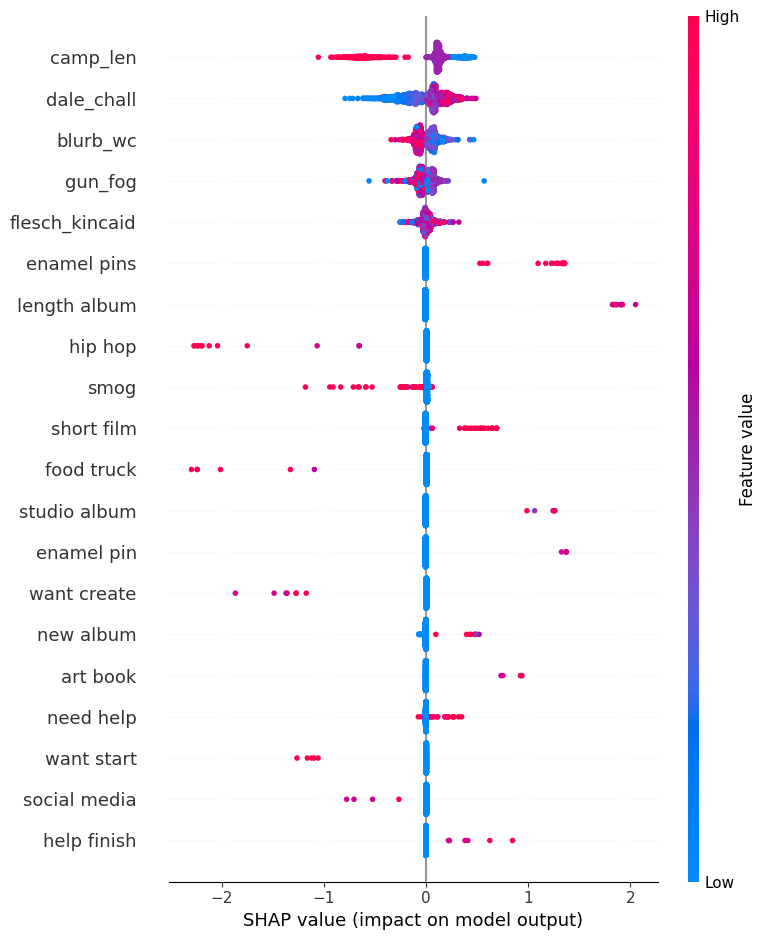

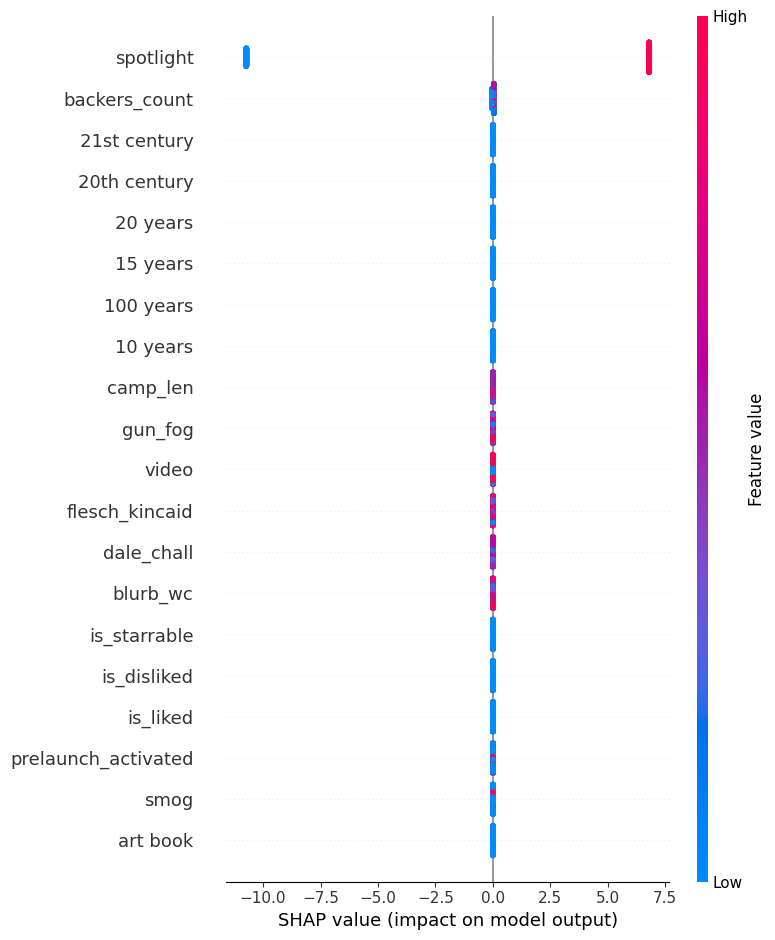

In [29]:
# Explain model 1 (text-only)
explainer_text = shap.TreeExplainer(model_text)
shap_values_text = explainer_text.shap_values(X_test_text)

shap.summary_plot(shap_values_text, X_test_text)

# Explain model 2 (all features)
explainer_all = shap.TreeExplainer(model_all)
shap_values_all = explainer_all.shap_values(X_test_all)

shap.summary_plot(shap_values_all, X_test_all)

In [ ]:
params = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [1, 3, 5],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.5, 1]
}

grid = GridSearchCV(XGBClassifier(eval_metric='logloss'), 
                    param_grid=params, 
                    scoring='roc_auc', 
                    cv=3, 
                    verbose=1)

grid.fit(X_train_all, y_train)
print("Best Params:", grid.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [ ]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_all, y_train)
rf_pred = rf.predict(X_test_all)
rf_proba = rf.predict_proba(X_test_all)[:, 1]
print("RF AUC:", roc_auc_score(y_test, rf_proba))
print("RF F1:", f1_score(y_test, rf_pred))

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_all, y_train)
lr_pred = lr.predict(X_test_all)
lr_proba = lr.predict_proba(X_test_all)[:, 1]
print("LR AUC:", roc_auc_score(y_test, lr_proba))
print("LR F1:", f1_score(y_test, lr_pred))


In [ ]:
features = ['percent_funded']  # or ['goal']

# Plot PDP and ICE
PartialDependenceDisplay.from_estimator(
    model_all,
    X_test_all,
    features,
    kind="both",  # "average", "individual", or "both"
    subsample=50,  # ICE can be dense; subsample for clarity
    grid_resolution=20,
    random_state=0
)

plt.tight_layout()
plt.show()


In [ ]:
PartialDependenceDisplay.from_estimator(
    model_all,
    X_test_all,
    features=['goal', 'percent_funded', 'readability_flesch'],  # replace with your actual column names
    kind="both"
)

In [ ]:
transformer.get_feature_names_out()